<a href="https://colab.research.google.com/github/gianniskandias/KR-Suite-docker/blob/master/speech_encoder_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kandias Ioannis-Christos (ikandias@di.uoa.gr) \
Tilemachos Tsiapras (ttsiapras@di.uoa.gr)

In [30]:
import torchaudio
from google.colab import drive
import torch
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import librosa
from torch import nn

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


If a complete dataset was existed.

In [ ]:
# read the sound paths
# TODO put the available directory if was existed

input_path = ...

dir = os.listdir(input_path)

wav_paths = [os.path.join(input_path, files) for files in dir]

In order to 1024 samples represent ~0.046ms in the time domain, we must have frequency of: $\frac{1024} {0.046} = 22260.86$ Hz.


In [6]:
# import a wav file from the created
wav_paths = [r'/content/gdrive/MyDrive/databases/speech2.wav']

In [26]:
# create the log-mel spectrograms

to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=22000, n_fft=1024, n_mels=96,
    hop_length=512, window_fn=torch.hann_window)

def log_mel_spectrograms(file_path):
  waveform, sr = torchaudio.load(file_path)
  return to_mel_spectrogram(waveform).log()

log_mel_specs = [log_mel_spectrograms(sound) for sound in wav_paths]

In [27]:
log_mel_specs

[tensor([[[ -8.0965,  -8.7951,  -8.3113,  ...,  -9.1818,  -9.2222, -12.7251],
          [ -8.9885, -10.8763,  -6.4539,  ..., -11.2107,  -9.1231,  -8.9341],
          [ -8.6498, -10.2505,  -7.9604,  ...,  -8.9209,  -8.1075,  -7.4514],
          ...,
          [ -9.2345,  -9.0875,  -9.5485,  ...,  -9.7256,  -9.6066,  -9.4501],
          [ -9.0197,  -8.8706,  -9.9140,  ..., -10.5400, -10.2543, -10.4753],
          [-10.7235, -11.7478, -10.3800,  ..., -12.4019, -12.4628, -10.8592]]])]

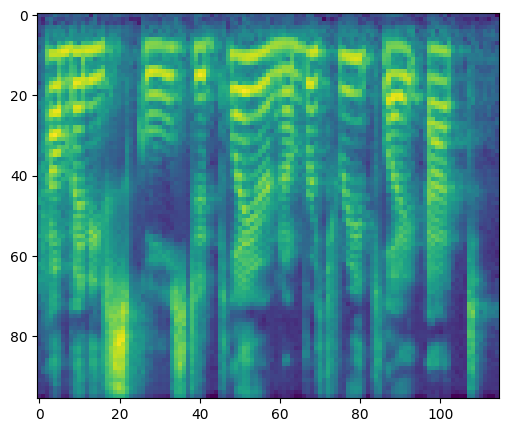

In [28]:
plt.figure(figsize=(18,5))
plt.imshow(log_mel_specs[0][0])

In [ ]:
# pad the different length images

max_width, max_height = max([i.shape[2] for i in log_mel_specs]), max([i.shape[1] for i in log_mel_specs])

images = [
          F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])
          for img in log_mel_specs
]

The architecture

In [33]:
class Speech_Encoder(nn.Module):
    def __init__(self):
        super(Speech_Encoder, self).__init__()
        self.conv1 = nn.Sequential(
                    nn.Conv2d(1, 4, 3),
                    nn.BatchNorm2d(4), #input is 4D.
                    nn.ReLU()
                    )

    def forward(self, x):
        x = self.conv1(x)

        for i in [8, 16, 32, 64, 128]:
          x = nn.Sequential(
                    nn.Conv2d(4, i, 3),
                    nn.BatchNorm2d(i),
                    nn.ReLU()
                    )(x)

        x = nn.Flatten(x)
        return x